In [114]:
import json
import pandas as pd
from candidate_data import candidates
import numpy as np

# Load JSON file
with open('campaign_documents.json', 'r') as file:
    campaign_data = json.load(file)

# Convert to DataFrame for easier handling
df = pd.DataFrame(campaign_data)

#iterate over the candidates and add a column to the dataframe for each candidate
df['party'] = df['speaker'].apply(lambda x: candidates[x]['party'])
df['president'] = df['speaker'].apply(lambda x: candidates[x]['president'])


# Extract relevant fields
texts = df['text']

In [115]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import faiss
import networkx as nx
import matplotlib.pyplot as plt


# Initialize the Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Step 1: Generate Sentence Embeddings in Batches
embeddings = []
batch_size = 1000

texts = texts.tolist()

print(len(texts))

for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    batch_embeddings = model.encode(batch, show_progress_bar=True)
    embeddings.append(batch_embeddings)

# Combine all embeddings into one array
embeddings = np.vstack(embeddings)

np.save('text_embeddings.npy', embeddings)

23516


Batches: 100%|██████████| 17/17 [00:11<00:00,  1.49it/s]


In [116]:
# Step 2: Dimensionality Reduction with PCA
# Reduce to 100 dimensions for faster similarity calculations
pca = PCA(n_components=100)
reduced_embeddings = pca.fit_transform(embeddings)

# Save reduced embeddings (optional)
np.save('reduced_text_embeddings.npy', reduced_embeddings)

In [117]:
# Step 3: Approximate Nearest Neighbors with FAISS
d = reduced_embeddings.shape[1]  # Dimensionality of embeddings
index = faiss.IndexFlatL2(d)     # Use L2 distance for similarity
index.add(reduced_embeddings)    # Add embeddings to the FAISS index

# Query for nearest neighbors
k = 10  # Number of neighbors to find for each text
distances, indices = index.search(reduced_embeddings, k)

23516
Number of nodes: 23516
Number of nodes: 23516
Number of edges: 159503


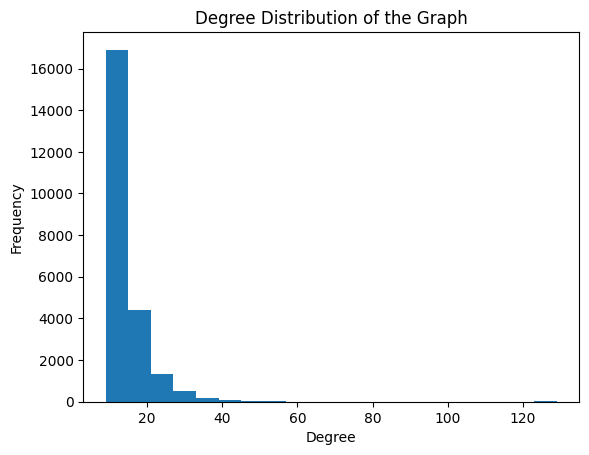

In [174]:
import networkx as nx

# Step 4: Create a Similarity Network
# Initialize graph
G = nx.Graph()

print(len(texts))

# Add nodes for each text
for i in range(len(texts)):
    G.add_node(i, title=df['title'][i], speaker=df['speaker'][i], party=df['party'][i], president=df['president'][i], date=df['date'][i])

print(f'Number of nodes: {G.number_of_nodes()}')

# Add edges for the top-k neighbors with weights based on similarity
for i, neighbors in enumerate(indices):
    for j, neighbor in enumerate(neighbors[1:]):  # Skip self-comparison at index 0
        G.add_edge(i, neighbor, weight=1 / (1 + distances[i][j+1]))

# Print the number of nodes and edges in the graph
print(f'Number of nodes: {G.number_of_nodes()}')
print(f'Number of edges: {G.number_of_edges()}')

# Print degree distribution
degrees = [val for (node, val) in G.degree()]
plt.hist(degrees, bins=20)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Graph')
plt.show()

Number of nodes: 23516
Number of edges: 159503


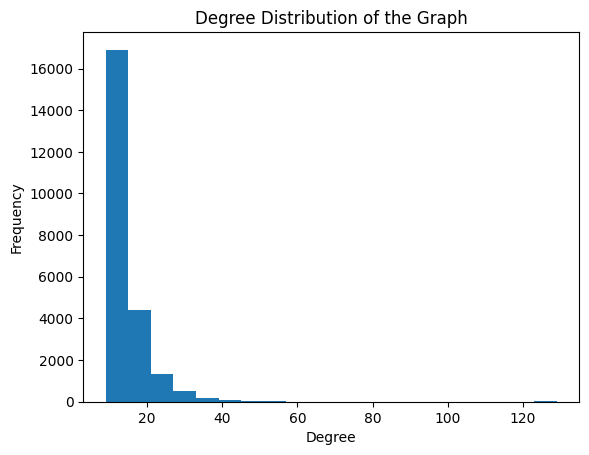

In [175]:
# Remove isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))

# Print the number of nodes and edges in the graph
print(f'Number of nodes: {G.number_of_nodes()}')
print(f'Number of edges: {G.number_of_edges()}')

#Plot the degree distribution
degrees = [val for (node, val) in G.degree()]
plt.hist(degrees, bins=20)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Graph')
plt.show()

In [176]:
#Get the top 100 nodes by degree
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:7500]
subgraph = G.subgraph([node for (node, degree) in top_nodes])

print(f'Number of nodes: {subgraph.number_of_nodes()}')

# plt.figure(figsize=(12, 12))
# pos = nx.spring_layout(subgraph, seed=42)
# nx.draw(subgraph, pos, with_labels=True, node_size=50, font_size=8, edge_color="gray", node_color="skyblue")
# plt.title("Text Similarity Network (Top 100 Nodes by Degree)")
# plt.show()

Number of nodes: 7500


In [177]:


#Convert president attribute to a yes or no from bool in the graph
president = nx.get_node_attributes(subgraph, 'president')

print(president)
president = {node: 'Yes' if val else 'No' for node, val in president.items()}
nx.set_node_attributes(subgraph, president, 'president')


{1: np.False_, 2: np.False_, 3: np.False_, 4: np.False_, 6: np.True_, 7: np.False_, 9: np.False_, 11: np.False_, 13: np.False_, 14: np.False_, 15: np.False_, 22: np.False_, 24: np.False_, 28: np.False_, 31: np.False_, 35: np.True_, 38: np.False_, 40: np.False_, 41: np.False_, 42: np.False_, 43: np.False_, 44: np.False_, 46: np.True_, 47: np.True_, 48: np.False_, 51: np.False_, 52: np.False_, 53: np.False_, 54: np.False_, 57: np.False_, 59: np.False_, 60: np.False_, 61: np.False_, 62: np.False_, 65: np.False_, 66: np.False_, 67: np.False_, 68: np.False_, 70: np.False_, 72: np.False_, 75: np.False_, 78: np.False_, 84: np.False_, 85: np.False_, 88: np.True_, 95: np.False_, 96: np.False_, 99: np.False_, 102: np.False_, 103: np.False_, 104: np.True_, 105: np.True_, 106: np.False_, 110: np.True_, 111: np.True_, 113: np.False_, 114: np.True_, 122: np.True_, 125: np.True_, 129: np.True_, 130: np.True_, 131: np.False_, 134: np.False_, 136: np.False_, 140: np.False_, 147: np.False_, 148: np.Fals

In [178]:
#genarate gexf file
nx.write_gexf(subgraph, 'campaign_speeches.gexf')